In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from chatsky_llm_autoconfig.settings import EnvSettings
env_settings = EnvSettings()
env_settings.GENERATION_MODEL_NAME

'gpt-3.5-turbo'

In [3]:
from chatsky_llm_autoconfig.graph import BaseGraph, Graph
from chatsky_llm_autoconfig.schemas import DialogueGraph
from chatsky_llm_autoconfig.dialogue import Dialogue, DialogueMessage
import json
import matplotlib.pyplot as plt
import numpy as np

/home/olshevskaya/miniconda3/envs/conda_env_py311/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "validate" in "Dialogue" shadows an attribute in parent "BaseModel"
  warnings.warn(


In [4]:
from chatsky_llm_autoconfig.algorithms.three_stages_1 import ThreeStagesGraphGenerator as Generator
from chatsky_llm_autoconfig.algorithms.three_stages_1i import ThreeStagesGraphGenerator as GeneratorI
from chatsky_llm_autoconfig.algorithms.three_stages_0i import ThreeStagesGraphGenerator as GeneratorI0
from chatsky_llm_autoconfig.algorithms.append_chain import AppendChain

from chatsky_llm_autoconfig.metrics.automatic_metrics import is_same_structure, triplet_match, compare_graphs
graph_generator = Generator("o3-mini") # To generate 1st graph from one dialogue
graph_generator_llm_emb = GeneratorI() # To add dialogue to existing graph: adding nodes with LLM and edges with embedder
graph_generator_llm = GeneratorI0() # To add dialogue to existing graph with LLM
graph_generator_llm_2 = AppendChain() # To add (append) dialogue to existing graph with LLM (the second approach)

# dataset exploring

In [5]:
path = '/cephfs/home/olshevskaya/chatsky-llm-autoconfig/experiments/2025.01.22_sampler/data/generated_24.json'
with open(path, 'r', encoding="utf-8") as f:
    generated_24 = json.load(f)

In [6]:
def get_dialogues_attrs_total(data, name_to_save, save=True):
    topics, dia_lens, uttr_lens = [], [], []
    i = 0

    for example in data:
        # add graph_id
        example['graph_id'] = i
        i += 1
        # collect topics, count dialogue and utterance length
        for dialogue in example['dialogues']:
            topics.append(dialogue['topic'])
            dia_lens.append(len(dialogue['messages']))
            uttr_len = [len(msg['text']) for msg in dialogue['messages']]
            uttr_lens += uttr_len
            
    if save:
        with open(name_to_save, "w", encoding="utf-8") as file:
            json.dump(data, file, indent=4, sort_keys=True)

    return data, dia_lens, uttr_lens, topics

In [7]:
def print_attr_stats(data, name):
    print(
        f'Stats:\n'
        f'Total count {len(data)}\n'
        f'min {np.min(data) :.0f} | mean {np.mean(data) :.0f} | max {np.max(data) :.0f}'
    )

    plt.title(name)
    plt.hist(data)
    plt.show()

In [8]:
generated_24, dia_lens, uttr_lens, topics = get_dialogues_attrs_total(generated_24, 'generated_24_with_ids.json')
len(dia_lens), len(uttr_lens), len(topics)

(277, 3077, 277)

Stats:
Total count 277
min 3 | mean 11 | max 27


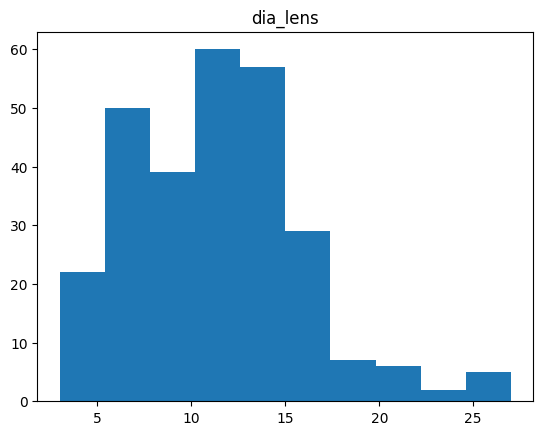

Stats:
Total count 3077
min 4 | mean 59 | max 354


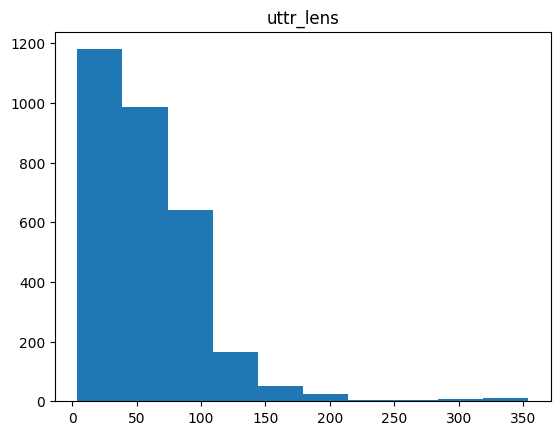

In [9]:
print_attr_stats(dia_lens, 'dia_lens')
print_attr_stats(uttr_lens, 'uttr_lens')

сколько диалогов имеют 10-15 реплик? сколько всего диалогов у каждого графа?

In [10]:
total_count = 0
total_count_all_dias = 0
for data in generated_24:
    count = 0
    count_all_dias = 0
    for dia in data['dialogues']:
        if len(dia['messages']) >= 10 and len(dia['messages']) <= 15:
            count += 1
        count_all_dias += 1
    print('graph', data['graph_id'], '- count:', count, '| count_all_dias:', count_all_dias)
    total_count += count
    total_count_all_dias += count_all_dias
total_count, total_count_all_dias

graph 0 - count: 0 | count_all_dias: 6
graph 1 - count: 10 | count_all_dias: 12
graph 2 - count: 8 | count_all_dias: 12
graph 3 - count: 2 | count_all_dias: 9
graph 4 - count: 2 | count_all_dias: 13
graph 5 - count: 7 | count_all_dias: 12
graph 6 - count: 5 | count_all_dias: 5
graph 7 - count: 16 | count_all_dias: 17
graph 8 - count: 6 | count_all_dias: 10
graph 9 - count: 1 | count_all_dias: 6
graph 10 - count: 13 | count_all_dias: 16
graph 11 - count: 5 | count_all_dias: 5
graph 12 - count: 4 | count_all_dias: 5
graph 13 - count: 1 | count_all_dias: 4
graph 14 - count: 8 | count_all_dias: 10
graph 15 - count: 0 | count_all_dias: 4
graph 16 - count: 3 | count_all_dias: 10
graph 17 - count: 18 | count_all_dias: 20
graph 18 - count: 13 | count_all_dias: 19
graph 19 - count: 1 | count_all_dias: 7
graph 20 - count: 3 | count_all_dias: 9
graph 21 - count: 0 | count_all_dias: 31
graph 22 - count: 13 | count_all_dias: 17
graph 23 - count: 0 | count_all_dias: 18


(139, 277)

In [11]:
import pandas as pd

In [33]:
df = pd.DataFrame()
for example in generated_24:
    df_row = pd.DataFrame(example['dialogues'])
    df_row['graph_id'] = example['graph_id']
    df = pd.concat([df, df_row])
    # break
df.reset_index(inplace=True, drop=True)
df.reset_index(inplace=True, names=['dialogue_id'])
df

,dialogue_id,messages,topic,validate,graph_id
0,0,[{'text': 'Hi there! How can I assist you toda...,,True,0
1,1,[{'text': 'Hi there! How can I assist you toda...,,True,0
2,2,[{'text': 'Hi there! How can I assist you toda...,,True,0
3,3,[{'text': 'Hi there! How can I assist you toda...,,True,0
4,4,[{'text': 'Hi there! How can I assist you toda...,,True,0
...,...,...,...,...,...
272,272,[{'text': 'Hello! I'm here to help you with us...,,True,23
273,273,[{'text': 'Hello! I'm here to help you with us...,,True,23
274,274,[{'text': 'Hello! I'm here to help you with us...,,True,23
275,275,[{'text': 'Hello! I'm here to help you with us...,,True,23


In [42]:
for i, row in df.iterrows():
    dia_len = len(row['messages'])
    for el in row['messages']:
        print(el)
    break

{'text': 'Hi there! How can I assist you today?', 'participant': 'assistant'}
{'text': 'I want to place an order.', 'participant': 'user'}
{'text': 'Great! What product are you interested in?', 'participant': 'assistant'}
{'text': 'I’d like a t-shirt.', 'participant': 'user'}
{'text': 'What size would you like?', 'participant': 'assistant'}
{'text': 'Medium, please.', 'participant': 'user'}
{'text': 'Would you like that in red or blue?', 'participant': 'assistant'}
{'text': 'Red, please.', 'participant': 'user'}
{'text': 'Perfect! Can I have your shipping address?', 'participant': 'assistant'}
{'text': 'Sure, it’s 123 Main St.', 'participant': 'user'}
{'text': 'Thank you! Your order has been placed. Is there anything else I can help you with?', 'participant': 'assistant'}
{'text': 'Actually, can I change my order?', 'participant': 'user'}
{'text': 'Of course! What would you like to change?', 'participant': 'assistant'}
{'text': 'I want a large size.', 'participant': 'user'}
{'text': 'W

# example

In [5]:
path = '/cephfs/home/olshevskaya/chatsky-llm-autoconfig/experiments/exp20250703_data_for_incrementation/exp20250703_data_for_incrementation/generated_24_with_ids.json'
with open(path, 'r', encoding="utf-8") as f:
    generated_24 = json.load(f)

In [8]:
for data in generated_24:
    if data['graph_id'] == 13:
        example = data
        break

Example: graph_id 13, 4 dialogues

True


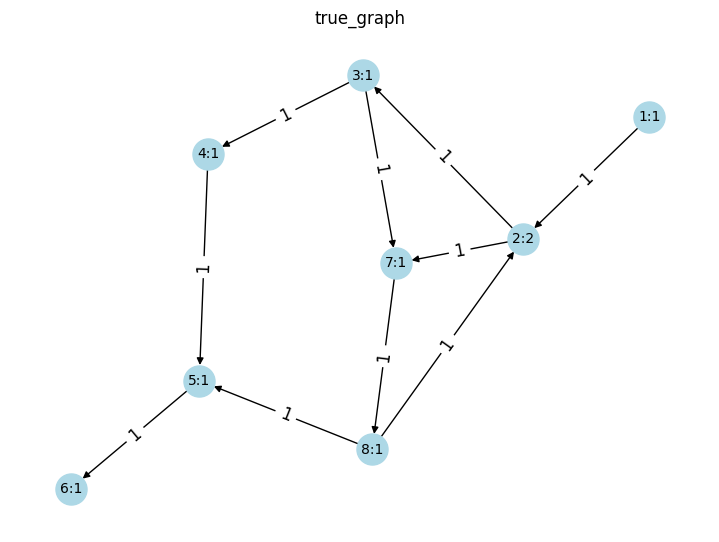

In [30]:
true_graph = Graph(graph_dict=example['graph'])
print(true_graph.edges_match_nodes())
true_graph.visualise_short('true_graph')

In [21]:
true_nodes = len(true_graph.graph_dict['nodes'])
true_edges = len(true_graph.graph_dict['edges'])
true_nodes, true_edges

(8, 10)

## first dialogue

In [68]:
dialogues = example['dialogues']
first_dialogue = Dialogue.from_list(dialogues[0]['messages'])
print(first_dialogue)

assistant: Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?
user: I'd like to learn about your NFT policies.
assistant: Certainly! Our approach to NFTs and digital assets is based on transparency and ethical collaborations. We ask influencers to clearly disclose any promotions related to digital assets and follow specific guidelines for creating and distributing content. Do you have any particular questions regarding these policies?
user: Actually, can I change my inquiry?
assistant: Of course! How would you like to modify your inquiry?
user: I'd like to learn about the partnership benefits instead.
assistant: Certainly! Our partnerships offer various benefits including competitive compensation, exclusive access to our digital asset platforms, and opportunities for co-branded campaigns. We support our influencers with dedicated resources to maximize the impact of their content. Would you like more details or to proceed with an application?


In [54]:
count_assistant, count_user = 0, 0
for msg in dialogues[0]['messages']:
    if msg['participant'] == 'assistant':
        count_assistant += 1
    elif msg['participant'] == 'user':
        count_user += 1
count_assistant, count_user
print(f'count_assistant: {count_assistant}, count_user: {count_user}')

count_assistant: 9, count_user: 8


graph_generator doesnt work with gpt-3.5-turbo

LLM
NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?']}, {'id': 2, 'label': 'ask_nft_policies', 'is_start': False, 'utterances': ['Certainly! Our approach to NFTs and digital assets is based on transparency and ethical collaborations. We ask influencers to clearly disclose any promotions related to digital assets and follow specific guidelines for creating and distributing content. Do you have any particular questions regarding these policies?']}, {'id': 3, 'label': 'modify_inquiry', 'is_start': False, 'utterances': ['Of course! How would you like to modify your inquiry?']}, {'id': 4, 'label': 'ask_partnership_benefits', 'is_start': False, 'utterances': ['Certainly! Our partnerships offer various benefits including competitive compensation, exclusive access to our digital asset platforms, and opportunities for co-branded campaigns. We support our influencers wi

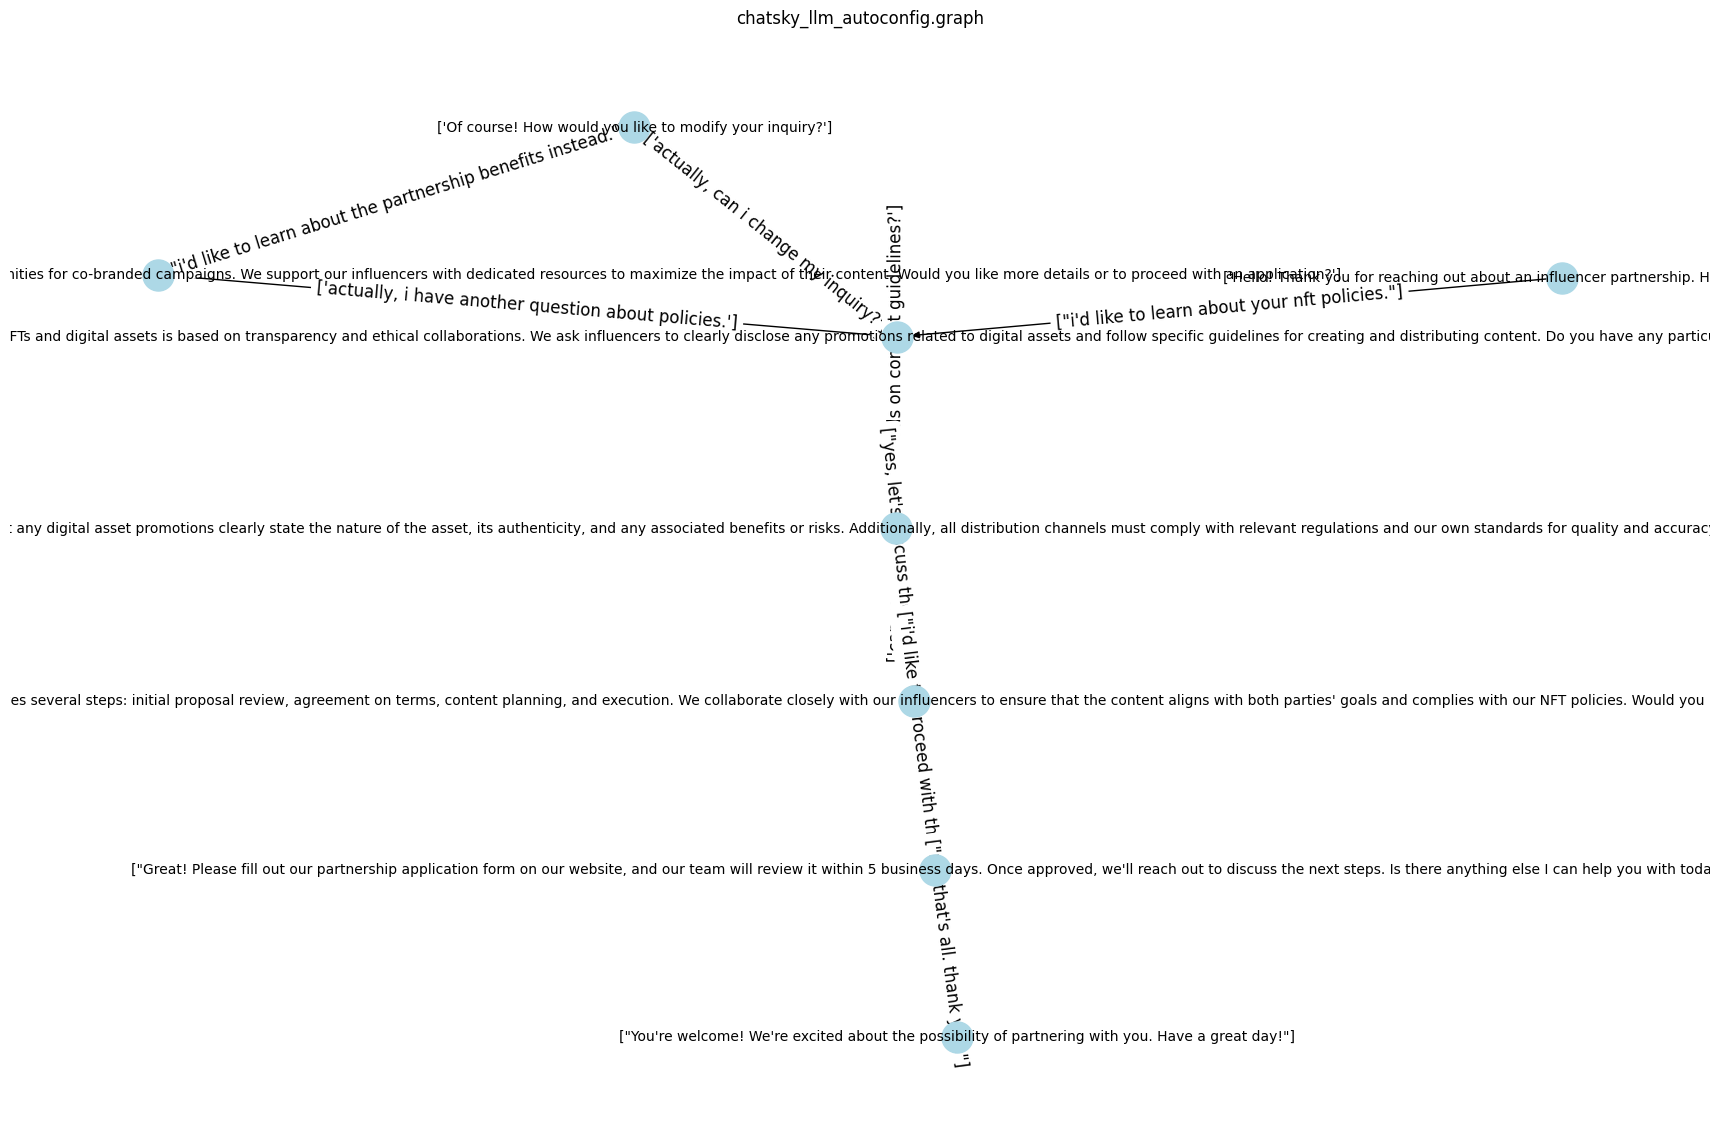

In [70]:
first_graph = graph_generator.invoke([first_dialogue])
print(first_graph.edges_match_nodes())
first_graph.visualise('first_graph')

In [76]:
print(all_utterances_present(first_graph, [first_dialogue]))
print(first_graph.edges_match_nodes())

Graph has all the dialogues
True
True


In [82]:
with open("first_graph_ThreeStagesGen_o3mini.json", "w", encoding="utf-8") as file:
    json.dump(first_graph.graph_dict, file, indent=4, sort_keys=True)

In [77]:
new_graph = first_graph.remove_duplicated_nodes()
if new_graph is None:
    print("Generated graph is wrong: utterances in nodes doubled")
else:
    if new_graph == first_graph:
        print('No duplicated nodes')
    else:
        print('There are duplicated nodes')

There are duplicated nodes


In [81]:
new_graph == first_graph

False

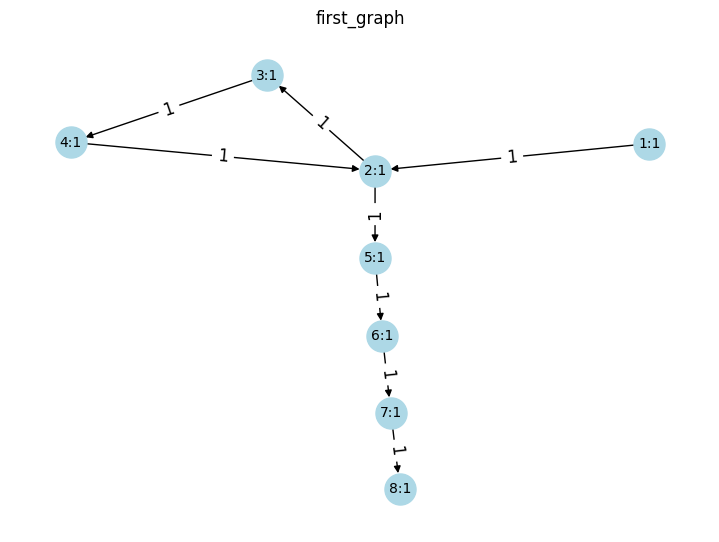

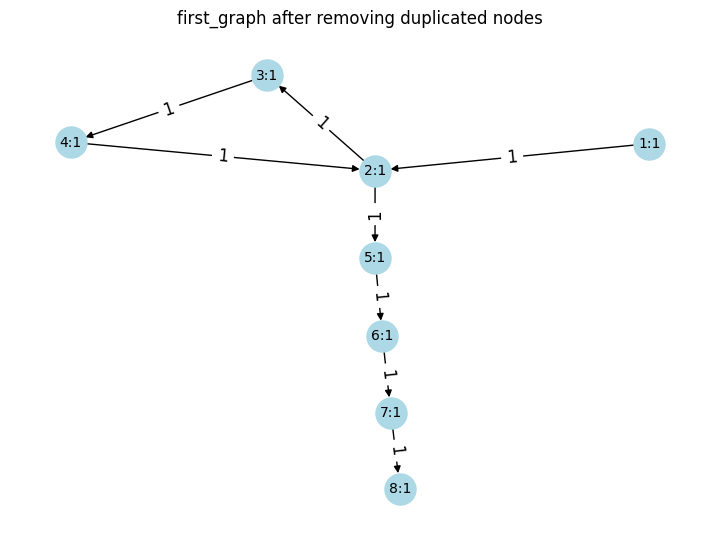

In [78]:
first_graph.visualise_short('first_graph')
new_graph.visualise_short('first_graph after removing duplicated nodes')

In [83]:
nodes = len(first_graph.graph_dict['nodes'])
edges = len(first_graph.graph_dict['edges'])
nodes, edges

(8, 8)

In [84]:
report = validate_graph(true_graph, first_graph)
report

BEFORE:  [(1, 2, {'theme': None, 'utterances': ["I'd like to learn about your NFT policies."], 'attrs': 1}), (2, 3, {'theme': None, 'utterances': ['Can you provide more details on content guidelines?'], 'attrs': 1}), (2, 7, {'theme': None, 'utterances': ['Actually, can I change my inquiry?'], 'attrs': 1}), (3, 4, {'theme': None, 'utterances': ["Yes, let's discuss the partnership process."], 'attrs': 1}), (3, 7, {'theme': None, 'utterances': ['Actually, I want to change my question.'], 'attrs': 1}), (4, 5, {'theme': None, 'utterances': ["I'd like to proceed with the application."], 'attrs': 1}), (5, 6, {'theme': None, 'utterances': ["No, that's all. Thank you."], 'attrs': 1}), (7, 8, {'theme': None, 'utterances': ["I'd like to learn about the partnership benefits instead."], 'attrs': 1}), (8, 5, {'theme': None, 'utterances': ["I'd like to proceed with the application."], 'attrs': 1}), (8, 2, {'theme': None, 'utterances': ['Actually, I have another question about policies.'], 'attrs': 1}

{'is_same_structure': False,
 'triplet_match': {'node_mapping': {1: None,
   2: None,
   3: None,
   4: None,
   5: None,
   6: None,
   7: None,
   8: None},
  'edge_mapping': {'1->2': None,
   '2->3': None,
   '2->7': None,
   '3->4': None,
   '3->7': None,
   '4->5': None,
   '5->6': None,
   '7->8': None,
   '8->5': None,
   '8->2': None}}}

## second dialogue

In [86]:
def count_uttr(dialogue):
    count_assistant, count_user = 0, 0
    for msg in dialogue:
        if msg['participant'] == 'assistant':
            count_assistant += 1
        elif msg['participant'] == 'user':
            count_user += 1
    return count_assistant, count_user

In [90]:
new_dialogue = Dialogue.from_list(dialogues[1]['messages'])
print(new_dialogue)
count_assistant, count_user = count_uttr(dialogues[1]['messages'])
print('-------------------------')
print(f'assistant: {count_assistant} utterances, user: {count_user} utterances')

assistant: Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?
user: I'd like to learn about your NFT policies.
assistant: Certainly! Our approach to NFTs and digital assets is based on transparency and ethical collaborations. We ask influencers to clearly disclose any promotions related to digital assets and follow specific guidelines for creating and distributing content. Do you have any particular questions regarding these policies?
user: Actually, can I change my inquiry?
assistant: Of course! How would you like to modify your inquiry?
user: I'd like to learn about the partnership benefits instead.
assistant: Certainly! Our partnerships offer various benefits including competitive compensation, exclusive access to our digital asset platforms, and opportunities for co-branded campaigns. We support our influencers with dedicated resources to maximize the impact of their content. Would you like more details or to proceed with an application?


In [92]:
result_graph_llm_emb, dialogues_ = graph_generator_llm_emb.invoke([new_dialogue], first_graph)

model:   gpt-3.5-turbo
LLM
Failed to parse DialogueNodes from completion {"nodes": [{"id": 1, "label": "start", "is_start": true, "utterances": ["Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?"]}, {"id": 2, "label": "ask_nft_policies", "is_start": false, "utterances": ["Certainly! Our approach to NFTs and digital assets is based on transparency and ethical collaborations. We ask influencers to clearly disclose any promotions related to digital assets and follow specific guidelines for creating and distributing content. Do you have any particular questions regarding these policies?", "Of course! Our NFT and digital asset policies ensure that all collaborations are transparent and ethical. We require influencers to clearly disclose any digital asset promotions and adhere to specific guidelines regarding content creation and distribution. Do you have any specific questions about these policies?"]}, {"id": 3, "label": "modify_inquiry", "is_st

AttributeError: 'NoneType' object has no attribute 'model_dump'

In [93]:
# add additional dialogue to the original graph and validate it
result_graph_llm = graph_generator_llm.invoke([new_dialogue], first_graph)

model:   gpt-3.5-turbo
LLM
RES:  {'edges': [{'source': 1, 'target': 2, 'utterances': ["i'd like to learn about your nft policies."]}, {'source': 2, 'target': 3, 'utterances': ['actually, can i change my inquiry?']}, {'source': 2, 'target': 5, 'utterances': ['can you provide more details on content guidelines?']}, {'source': 3, 'target': 4, 'utterances': ["i'd like to learn about the partnership benefits instead."]}, {'source': 4, 'target': 2, 'utterances': ['actually, i have another question about policies.']}, {'source': 5, 'target': 6, 'utterances': ["yes, let's discuss the partnership process."]}, {'source': 6, 'target': 7, 'utterances': ["i'd like to proceed with the application."]}, {'source': 7, 'target': 8, 'utterances': ["no, that's all. thank you."]}], 'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?']}, {'id': 2, 'label': 'ask_nft_policies', 'is_start': False,

In [96]:
with open("result_graph_llm_ThreeStagesGen_gpt35turbo_1.json", "w", encoding="utf-8") as file:
    json.dump(result_graph_llm.graph_dict, file, indent=4, sort_keys=True)

In [98]:
new_graph = result_graph_llm.remove_duplicated_nodes()
if new_graph is None:
    print("Generated graph is wrong: utterances in nodes doubled")
else:
    if new_graph.graph_dict == result_graph_llm.graph_dict:
        print('No duplicated nodes')
    else:
        print('There are duplicated nodes')

No duplicated nodes


In [99]:
nodes = len(result_graph_llm.graph_dict['nodes'])
edges = len(result_graph_llm.graph_dict['edges'])
nodes, edges

(8, 8)

In [100]:
report = validate_graph(true_graph, result_graph_llm)
report

BEFORE:  [(1, 2, {'theme': None, 'utterances': ["I'd like to learn about your NFT policies."], 'attrs': 1}), (2, 3, {'theme': None, 'utterances': ['Can you provide more details on content guidelines?'], 'attrs': 1}), (2, 7, {'theme': None, 'utterances': ['Actually, can I change my inquiry?'], 'attrs': 1}), (3, 4, {'theme': None, 'utterances': ["Yes, let's discuss the partnership process."], 'attrs': 1}), (3, 7, {'theme': None, 'utterances': ['Actually, I want to change my question.'], 'attrs': 1}), (4, 5, {'theme': None, 'utterances': ["I'd like to proceed with the application."], 'attrs': 1}), (5, 6, {'theme': None, 'utterances': ["No, that's all. Thank you."], 'attrs': 1}), (7, 8, {'theme': None, 'utterances': ["I'd like to learn about the partnership benefits instead."], 'attrs': 1}), (8, 5, {'theme': None, 'utterances': ["I'd like to proceed with the application."], 'attrs': 1}), (8, 2, {'theme': None, 'utterances': ['Actually, I have another question about policies.'], 'attrs': 1}

{'is_same_structure': False,
 'triplet_match': {'node_mapping': {1: None,
   2: None,
   3: None,
   4: None,
   5: None,
   6: None,
   7: None,
   8: None},
  'edge_mapping': {'1->2': None,
   '2->3': None,
   '2->7': None,
   '3->4': None,
   '3->7': None,
   '4->5': None,
   '5->6': None,
   '7->8': None,
   '8->5': None,
   '8->2': None}}}

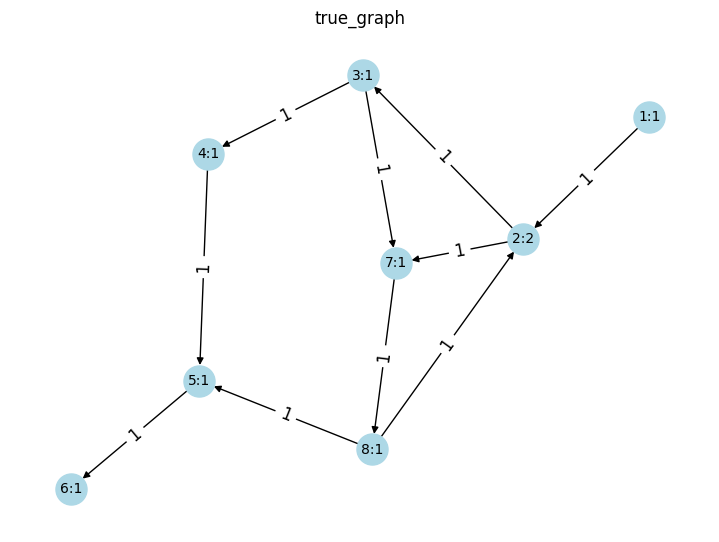

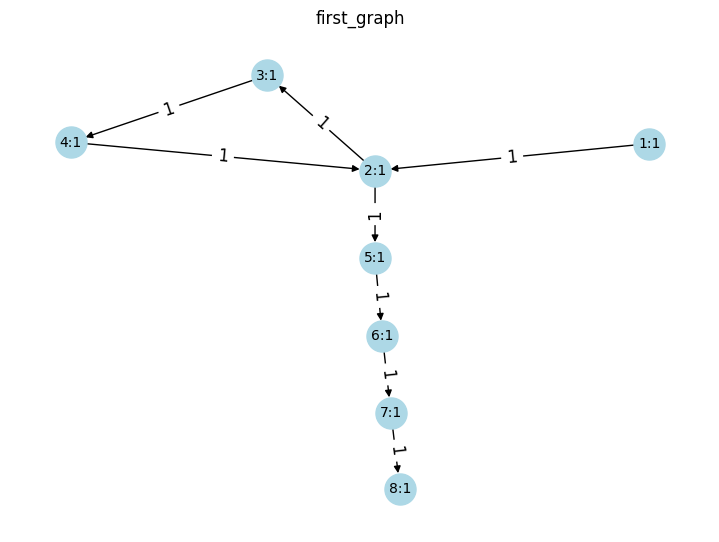

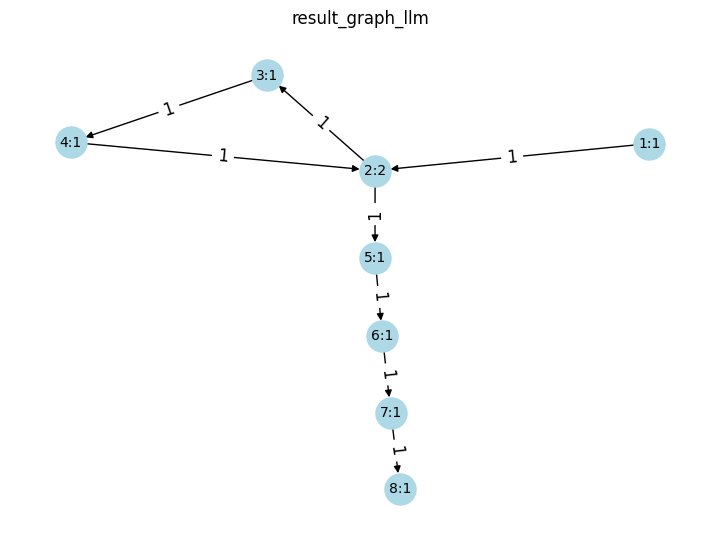

In [101]:
true_graph.visualise_short('true_graph')
first_graph.visualise_short('first_graph')
result_graph_llm.visualise_short('result_graph_llm')

all utterances except one is the same in these 2 dialogues

In [110]:
for uttr1, uttr2 in zip(first_dialogue.messages, new_dialogue.messages):
    if uttr1.text != uttr2.text:
        print(uttr1.text)
        print(uttr2.text)
        print('-----------')

Certainly! Our approach to NFTs and digital assets is based on transparency and ethical collaborations. We ask influencers to clearly disclose any promotions related to digital assets and follow specific guidelines for creating and distributing content. Do you have any particular questions regarding these policies?
Of course! Our NFT and digital asset policies ensure that all collaborations are transparent and ethical. We require influencers to clearly disclose any digital asset promotions and adhere to specific guidelines regarding content creation and distribution. Do you have any specific questions about these policies?
-----------


In [111]:
compare_graphs(result_graph_llm, first_graph)

LEN1:  [1, 1, 1, 1, 1, 1, 1, 1] LEN2:  [1, 1, 1, 1, 1, 1, 1, 1]
MAX:  [0, 1, 2, 3, 4, 5, 6, 7]
N_MAX:  [0, 1, 2, 3, 4, 5, 6, 7]
NODES:  0.970263
ALL:  0.9663145


True

In [103]:
compare_graphs(true_graph, first_graph)

LEN1:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] LEN2:  [1, 1, 1, 1, 1, 1, 1, 1]
MAX:  [0, 1, 4, 5, 6, 7, 2, 3]
N_MAX:  [0, 1, 4, 5, 6, 7, 2, 3]
N!


False

In [104]:
compare_graphs(true_graph, result_graph_llm)

LEN1:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] LEN2:  [1, 1, 1, 1, 1, 1, 1, 1]
MAX:  [0, 1, 4, 5, 6, 7, 2, 3]
N_MAX:  [0, 1, 4, 5, 6, 7, 2, 3]
N!


False

# generation

## functions

In [5]:
def validate_one_graph(graph, report=False):
    print(f'edges_match_nodes:', graph.edges_match_nodes(), '\n--------------')

    new_graph = graph.remove_duplicated_nodes()
    if new_graph is None:
        print("Generated graph is wrong: utterances in nodes doubled")
    else:
        if new_graph.graph_dict == graph.graph_dict:
            print('No duplicated nodes in the graph')
        else:
            print('There are duplicated nodes in the graph')
    print('---------------')

    nodes = len(graph.graph_dict['nodes'])
    edges = len(graph.graph_dict['edges'])
    print(f'Nodes: {nodes}, edges: {edges}')

In [6]:
def validate_2_graphs(original_graph, result_graph):
    val_report = {}
    val_report['is_same_structure'] = is_same_structure(original_graph, result_graph)
    node_mapping, edge_mapping = triplet_match(original_graph, result_graph)
    val_report['triplet_match'] = {
        'node_mapping' : None,
        'edge_mapping' : None
        }
    val_report['triplet_match']['node_mapping'] = node_mapping
    val_report['triplet_match']['edge_mapping'] = edge_mapping
    
    return val_report

Compare_graphs пока не используется для каждого сгенерированного графа, т.к. она задействует LLM

In [7]:
def count_uttr(dialogue):
    count_assistant, count_user = 0, 0
    for msg in dialogue:
        if msg['participant'] == 'assistant':
            count_assistant += 1
        elif msg['participant'] == 'user':
            count_user += 1
    return count_assistant, count_user

In [8]:
path = '/cephfs/home/olshevskaya/chatsky-llm-autoconfig/experiments/exp20250703_data_for_incrementation/exp20250703_data_for_incrementation/generated_24_with_ids.json'
with open(path, 'r', encoding="utf-8") as f:
    generated_24 = json.load(f)

## gpt-3.5-turbo, three_stages_generator

In [9]:
for data in generated_24:
    if data['graph_id'] == 13:
        example = data
        break

edges_match_nodes: True 
--------------
No duplicated nodes in the graph
---------------
Nodes: 8, edges: 10


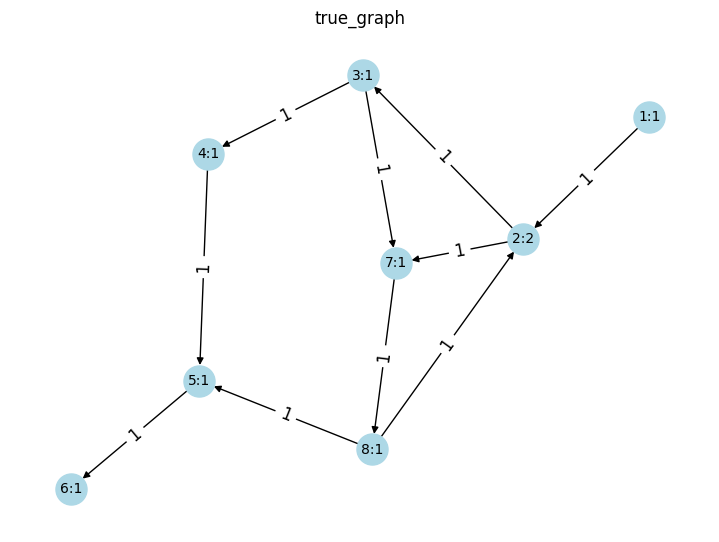

In [12]:
graph_id = 13
for data in generated_24:
    if data['graph_id'] == graph_id:
        example = data
        break

true_graph = Graph(graph_dict=example['graph'])
validate_one_graph(true_graph)
true_graph.visualise_short('true_graph')

**first dialogue**

In [35]:
dialogues = example['dialogues']
first_dialogue = Dialogue.from_list(dialogues[0]['messages'])
print(first_dialogue)
print('-------------------------')
count_assistant, count_user = count_uttr(dialogues[0]['messages'])
print(f'assistant: {count_assistant} utterances, user: {count_user} utterances')

assistant: Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?
user: I'd like to learn about your NFT policies.
assistant: Certainly! Our approach to NFTs and digital assets is based on transparency and ethical collaborations. We ask influencers to clearly disclose any promotions related to digital assets and follow specific guidelines for creating and distributing content. Do you have any particular questions regarding these policies?
user: Actually, can I change my inquiry?
assistant: Of course! How would you like to modify your inquiry?
user: I'd like to learn about the partnership benefits instead.
assistant: Certainly! Our partnerships offer various benefits including competitive compensation, exclusive access to our digital asset platforms, and opportunities for co-branded campaigns. We support our influencers with dedicated resources to maximize the impact of their content. Would you like more details or to proceed with an application?


In [125]:
first_graph = graph_generator.invoke([first_dialogue])
validate_one_graph(first_graph)

LLM
NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?']}, {'id': 2, 'label': 'nft_policies', 'is_start': False, 'utterances': ['Certainly! Our approach to NFTs and digital assets is based on transparency and ethical collaborations. We ask influencers to clearly disclose any promotions related to digital assets and follow specific guidelines for creating and distributing content. Do you have any particular questions regarding these policies?']}, {'id': 3, 'label': 'modify_inquiry', 'is_start': False, 'utterances': ['Of course! How would you like to modify your inquiry?']}, {'id': 4, 'label': 'partnership_benefits', 'is_start': False, 'utterances': ['Certainly! Our partnerships offer various benefits including competitive compensation, exclusive access to our digital asset platforms, and opportunities for co-branded campaigns. We support our influencers with dedic

In [ ]:
# with open("first_graph_ThreeStagesGen_o3mini.json", "w", encoding="utf-8") as file:
#     json.dump(first_graph.graph_dict, file, indent=4, sort_keys=True)

In [13]:
with open("first_graph_ThreeStagesGen_o3mini.json", 'r', encoding="utf-8") as f:
    graph_dict = json.load(f)
first_graph = Graph(graph_dict=graph_dict)

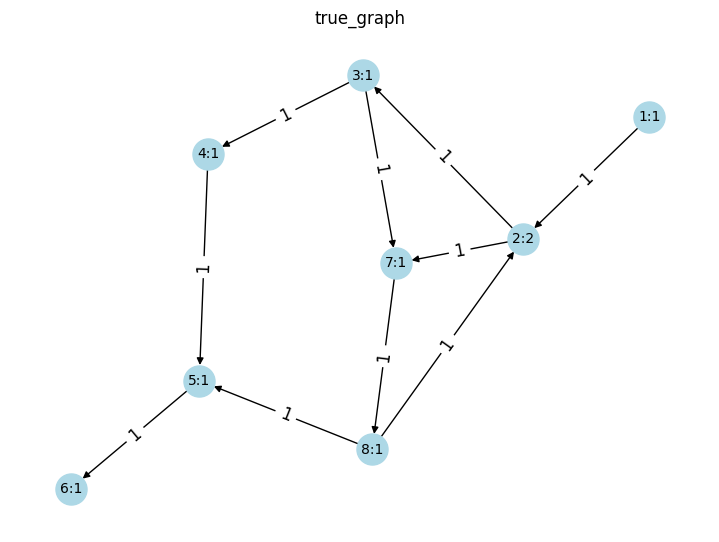

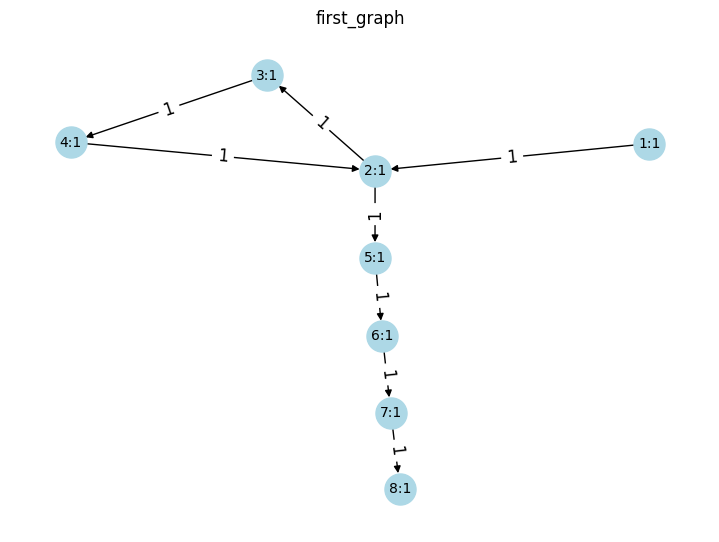

In [12]:
true_graph.visualise_short('true_graph')
first_graph.visualise_short('first_graph')

In [14]:
validate_2_graphs(true_graph, first_graph)

(10, 8)
{1: ['Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?'], 2: ['Certainly! Our approach to NFTs and digital assets is based on transparency and ethical collaborations. We ask influencers to clearly disclose any promotions related to digital assets and follow specific guidelines for creating and distributing content. Do you have any particular questions regarding these policies?', 'Of course! Our NFT and digital asset policies ensure that all collaborations are transparent and ethical. We require influencers to clearly disclose any digital asset promotions and adhere to specific guidelines regarding content creation and distribution. Do you have any specific questions about these policies?'], 3: ['Certainly! For content creation, we require that any digital asset promotions clearly state the nature of the asset, its authenticity, and any associated benefits or risks. Additionally, all distribution channels must comply with relevant re

{'is_same_structure': False,
 'triplet_match': {'node_mapping': {1: None,
   2: None,
   3: None,
   4: None,
   5: None,
   6: None,
   7: None,
   8: None},
  'edge_mapping': {'1->2': None,
   '2->3': None,
   '2->7': None,
   '3->4': None,
   '3->7': None,
   '4->5': None,
   '5->6': None,
   '7->8': None,
   '8->5': None,
   '8->2': None}}}

**second dialogue**

In [10]:
new_dialogue = Dialogue.from_list(dialogues[0]['messages'])
print(new_dialogue)
count_assistant, count_user = count_uttr(dialogues[1]['messages'])
print('-------------------------')
print(f'assistant: {count_assistant} utterances, user: {count_user} utterances')

NameError: name 'dialogues' is not defined

In [18]:
new_dialogue = Dialogue.from_list(dialogues[1]['messages'])
print(new_dialogue)
count_assistant, count_user = count_uttr(dialogues[1]['messages'])
print('-------------------------')
print(f'assistant: {count_assistant} utterances, user: {count_user} utterances')

assistant: Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?
user: I'd like to learn about your NFT policies.
assistant: Certainly! Our approach to NFTs and digital assets is based on transparency and ethical collaborations. We ask influencers to clearly disclose any promotions related to digital assets and follow specific guidelines for creating and distributing content. Do you have any particular questions regarding these policies?
user: Actually, can I change my inquiry?
assistant: Of course! How would you like to modify your inquiry?
user: I'd like to learn about the partnership benefits instead.
assistant: Certainly! Our partnerships offer various benefits including competitive compensation, exclusive access to our digital asset platforms, and opportunities for co-branded campaigns. We support our influencers with dedicated resources to maximize the impact of their content. Would you like more details or to proceed with an application?


Диалоги 0 и 1 отличаются только одной репликой.

In [ ]:
result_graph = graph_generator_llm.invoke([new_dialogue], first_graph)

In [20]:
validate_one_graph(result_graph)

edges_match_nodes: True 
--------------
No duplicated nodes in the graph
---------------
Nodes: 8, edges: 8


In [ ]:
# with open("result_graph_llm_ThreeStagesGen_gpt35turbo_1.json", "w", encoding="utf-8") as file:
#     json.dump(result_graph.graph_dict, file, indent=4, sort_keys=True)

In [13]:
with open("result_graph_llm_ThreeStagesGen_gpt35turbo_1.json", 'r', encoding="utf-8") as f:
    graph_dict = json.load(f)
result_graph = Graph(graph_dict=graph_dict)

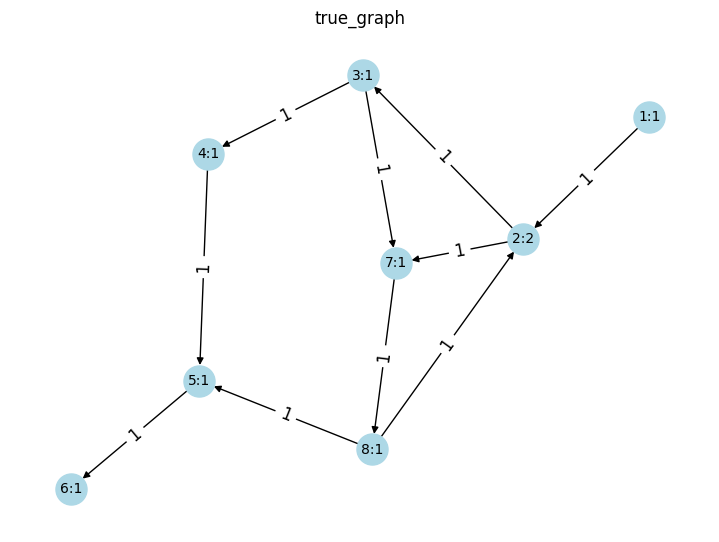

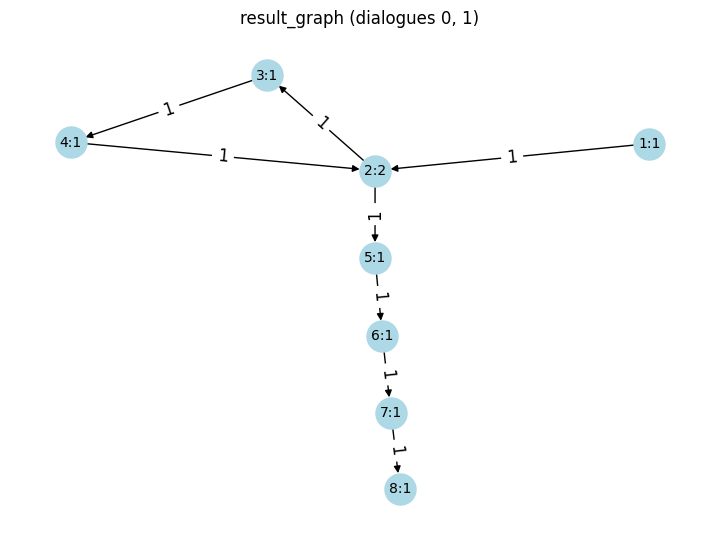

In [34]:
true_graph.visualise_short('true_graph')
result_graph.visualise_short('result_graph (dialogues 0, 1)')

In [ ]:
validate_2_graphs(true_graph, result_graph)

(10, 8)
{1: ['Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?'], 2: ['Certainly! Our approach to NFTs and digital assets is based on transparency and ethical collaborations. We ask influencers to clearly disclose any promotions related to digital assets and follow specific guidelines for creating and distributing content. Do you have any particular questions regarding these policies?', 'Of course! Our NFT and digital asset policies ensure that all collaborations are transparent and ethical. We require influencers to clearly disclose any digital asset promotions and adhere to specific guidelines regarding content creation and distribution. Do you have any specific questions about these policies?'], 3: ['Certainly! For content creation, we require that any digital asset promotions clearly state the nature of the asset, its authenticity, and any associated benefits or risks. Additionally, all distribution channels must comply with relevant re

{'is_same_structure': False,
 'triplet_match': {'node_mapping': {1: None,
   2: None,
   3: None,
   4: None,
   5: None,
   6: None,
   7: None,
   8: None},
  'edge_mapping': {'1->2': None,
   '2->3': None,
   '2->7': None,
   '3->4': None,
   '3->7': None,
   '4->5': None,
   '5->6': None,
   '7->8': None,
   '8->5': None,
   '8->2': None}}}

**third dialogue**

In [49]:
new_dialogue = Dialogue.from_list(dialogues[2]['messages'])
print(new_dialogue)
count_assistant, count_user = count_uttr(dialogues[2]['messages'])
print('-------------------------')
print(f'assistant: {count_assistant} utterances, user: {count_user} utterances')

assistant: Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?
user: I'd like to learn about your NFT policies.
assistant: Of course! Our NFT and digital asset policies ensure that all collaborations are transparent and ethical. We require influencers to clearly disclose any digital asset promotions and adhere to specific guidelines regarding content creation and distribution. Do you have any specific questions about these policies?
user: Actually, can I change my inquiry?
assistant: Of course! How would you like to modify your inquiry?
user: I'd like to learn about the partnership benefits instead.
assistant: Certainly! Our partnerships offer various benefits including competitive compensation, exclusive access to our digital asset platforms, and opportunities for co-branded campaigns. We support our influencers with dedicated resources to maximize the impact of their content. Would you like more details or to proceed with an application?
use

Диалоги 0, 1 и 2 в совокупности отличаются только 2 репликами.

In [ ]:
result_graph = graph_generator_llm.invoke([new_dialogue], result_graph)
validate_one_graph(result_graph)

with open("result_graph_llm_ThreeStagesGen_gpt35turbo_2.json", "w", encoding="utf-8") as file:
    json.dump(result_graph.graph_dict, file, indent=4, sort_keys=True)

In [50]:
with open("result_graph_llm_ThreeStagesGen_gpt35turbo_2.json", 'r', encoding="utf-8") as f:
    graph_dict = json.load(f)
result_graph = Graph(graph_dict=graph_dict)

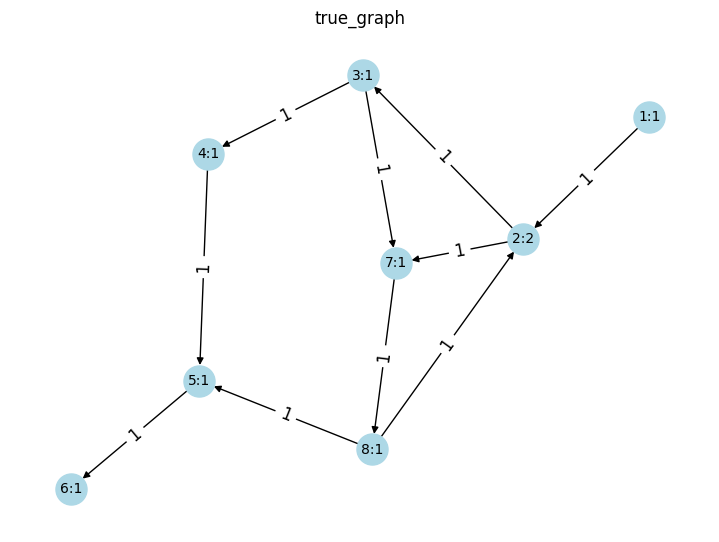

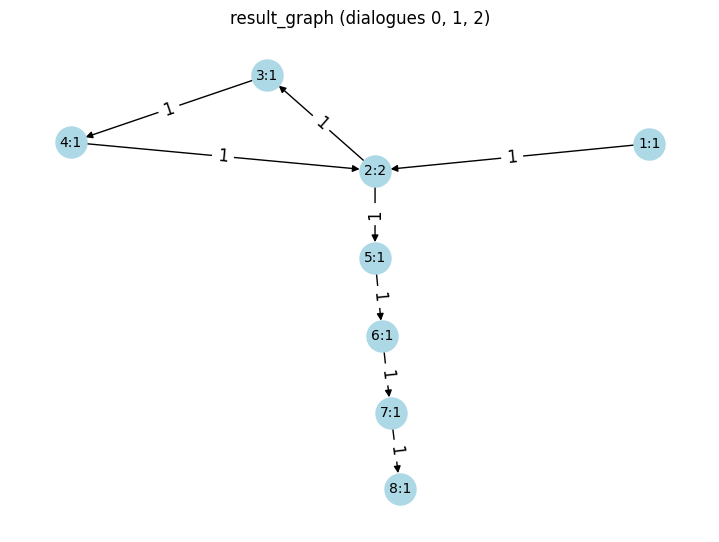

(10, 8)
{1: ['Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?'], 2: ['Certainly! Our approach to NFTs and digital assets is based on transparency and ethical collaborations. We ask influencers to clearly disclose any promotions related to digital assets and follow specific guidelines for creating and distributing content. Do you have any particular questions regarding these policies?', 'Of course! Our NFT and digital asset policies ensure that all collaborations are transparent and ethical. We require influencers to clearly disclose any digital asset promotions and adhere to specific guidelines regarding content creation and distribution. Do you have any specific questions about these policies?'], 3: ['Certainly! For content creation, we require that any digital asset promotions clearly state the nature of the asset, its authenticity, and any associated benefits or risks. Additionally, all distribution channels must comply with relevant re

{'is_same_structure': False,
 'triplet_match': {'node_mapping': {1: None,
   2: None,
   3: None,
   4: None,
   5: None,
   6: None,
   7: None,
   8: None},
  'edge_mapping': {'1->2': None,
   '2->3': None,
   '2->7': None,
   '3->4': None,
   '3->7': None,
   '4->5': None,
   '5->6': None,
   '7->8': None,
   '8->5': None,
   '8->2': None}}}

In [ ]:
true_graph.visualise_short('true_graph')
result_graph.visualise_short('result_graph (dialogues 0, 1, 2)')
validate_2_graphs(true_graph, result_graph)

**fourth dialogue**

In [46]:
new_dialogue = Dialogue.from_list(dialogues[3]['messages'])
print(new_dialogue)
count_assistant, count_user = count_uttr(dialogues[3]['messages'])
print('-------------------------')
print(f'assistant: {count_assistant} utterances, user: {count_user} utterances')

assistant: Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?
user: I'd like to learn about your NFT policies.
assistant: Certainly! Our approach to NFTs and digital assets is based on transparency and ethical collaborations. We ask influencers to clearly disclose any promotions related to digital assets and follow specific guidelines for creating and distributing content. Do you have any particular questions regarding these policies?
user: Can you provide more details on content guidelines?
assistant: Certainly! For content creation, we require that any digital asset promotions clearly state the nature of the asset, its authenticity, and any associated benefits or risks. Additionally, all distribution channels must comply with relevant regulations and our own standards for quality and accuracy. Would you like to discuss the partnership process next?
user: Actually, I want to change my question.
assistant: Of course! How would you like to mod

Диалог 3 в большей степени отличается от диалогов 0-2, также он короче.

In [47]:
result_graph = graph_generator_llm.invoke([new_dialogue], result_graph)
validate_one_graph(result_graph)

with open("result_graph_llm_ThreeStagesGen_gpt35turbo_3.json", "w", encoding="utf-8") as file:
    json.dump(result_graph.graph_dict, file, indent=4, sort_keys=True)

model:   gpt-3.5-turbo
LLM


INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


RES:  {'edges': [{'source': 1, 'target': 2, 'utterances': ["i'd like to learn about your nft policies."]}, {'source': 2, 'target': 3, 'utterances': ['actually, can i change my inquiry?']}, {'source': 2, 'target': 5, 'utterances': ['can you provide more details on content guidelines?']}, {'source': 3, 'target': 4, 'utterances': ["i'd like to learn about the partnership benefits instead."]}, {'source': 4, 'target': 2, 'utterances': ['actually, i have another question about policies.']}, {'source': 5, 'target': 6, 'utterances': ["yes, let's discuss the partnership process."]}, {'source': 6, 'target': 7, 'utterances': ["i'd like to proceed with the application."]}, {'source': 7, 'target': 8, 'utterances': ["no, that's all. thank you."]}], 'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?']}, {'id': 2, 'label': 'ask_nft_policies', 'is_start': False, 'utterances': ['Certainly!

In [52]:
with open("result_graph_llm_ThreeStagesGen_gpt35turbo_3.json", 'r', encoding="utf-8") as f:
    graph_dict = json.load(f)
result_graph = Graph(graph_dict=graph_dict)

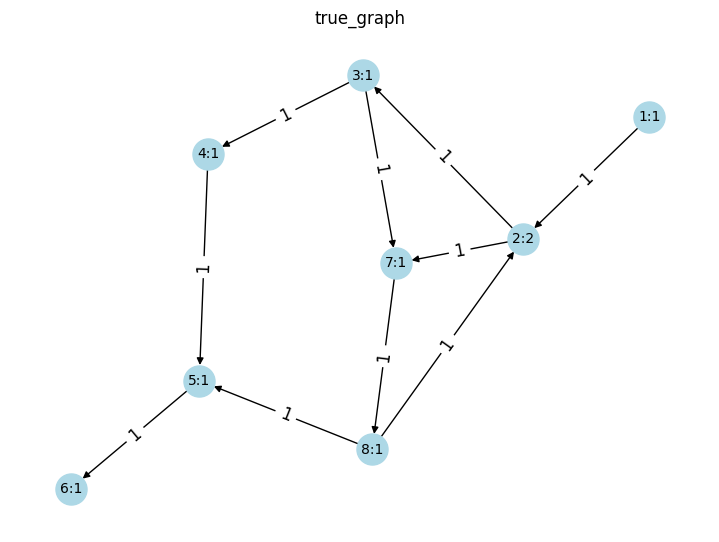

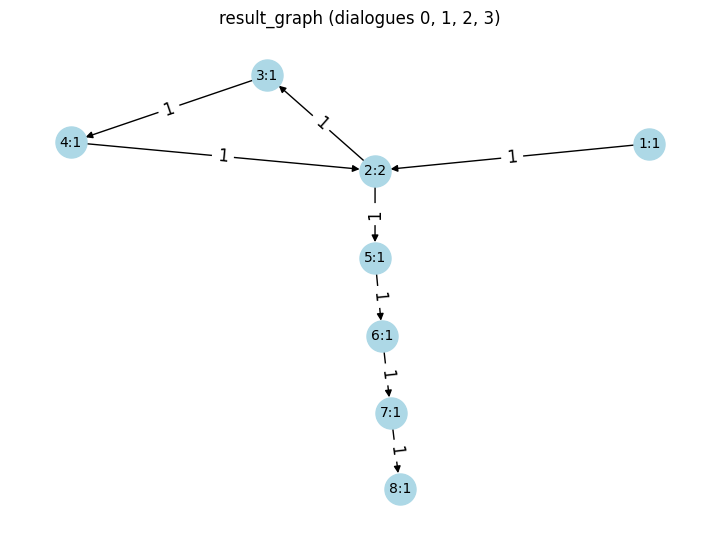

(10, 8)
{1: ['Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?'], 2: ['Certainly! Our approach to NFTs and digital assets is based on transparency and ethical collaborations. We ask influencers to clearly disclose any promotions related to digital assets and follow specific guidelines for creating and distributing content. Do you have any particular questions regarding these policies?', 'Of course! Our NFT and digital asset policies ensure that all collaborations are transparent and ethical. We require influencers to clearly disclose any digital asset promotions and adhere to specific guidelines regarding content creation and distribution. Do you have any specific questions about these policies?'], 3: ['Certainly! For content creation, we require that any digital asset promotions clearly state the nature of the asset, its authenticity, and any associated benefits or risks. Additionally, all distribution channels must comply with relevant re

{'is_same_structure': False,
 'triplet_match': {'node_mapping': {1: None,
   2: None,
   3: None,
   4: None,
   5: None,
   6: None,
   7: None,
   8: None},
  'edge_mapping': {'1->2': None,
   '2->3': None,
   '2->7': None,
   '3->4': None,
   '3->7': None,
   '4->5': None,
   '5->6': None,
   '7->8': None,
   '8->5': None,
   '8->2': None}}}

In [ ]:
true_graph.visualise_short('true_graph')
result_graph.visualise_short('result_graph (dialogues 0, 1, 2, 3)')
validate_2_graphs(true_graph, result_graph)

In [54]:
compare_graphs(result_graph, true_graph)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


LEN1:  [1, 1, 1, 1, 1, 1, 1, 1] LEN2:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

MAX:  [0, 1, 6, 7, 2, 3, 4, 5]
N_MAX:  [0, 1, 6, 7, 2, 3, 4, 5]
N!


False

## gpt-3.5-turbo, append_chain

In [10]:
def get_true_graph_and_dialogues(dataset, graph_id):
    for data in dataset:
        if data['graph_id'] == graph_id:
            example = data
            break
    true_graph = Graph(graph_dict=example['graph'])
    validate_one_graph(true_graph)
    true_graph.visualise_short('true_graph')

    dialogues = example['dialogues']
    
    return true_graph, dialogues

In [11]:
def get_one_dialogue(dialogues, index):
    new_dialogue = Dialogue.from_list(dialogues[index]['messages'])
    count_assistant, count_user = count_uttr(dialogues[index]['messages'])
    print(new_dialogue)
    print('-------------------------')    
    print(f'assistant: {count_assistant} utterances, user: {count_user} utterances')
    return new_dialogue

edges_match_nodes: True 
--------------
No duplicated nodes in the graph
---------------
Nodes: 8, edges: 10


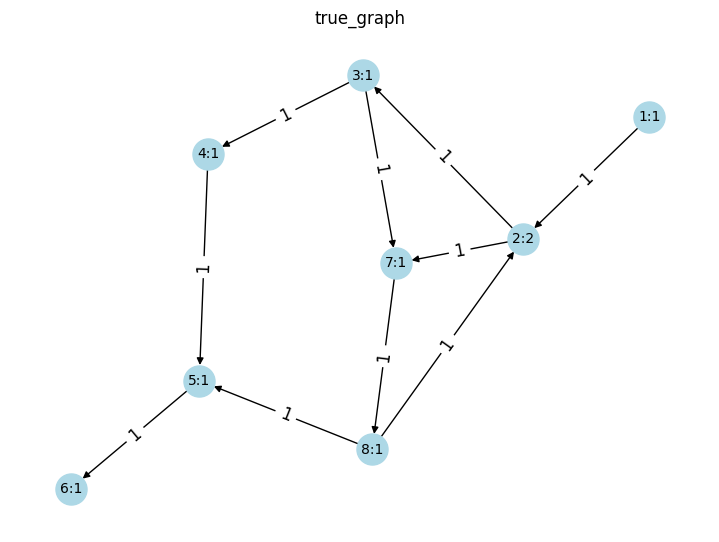

In [12]:
true_graph, dialogues = get_true_graph_and_dialogues(generated_24, 13)

**dialogue 0**

assistant: Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?
user: I'd like to learn about your NFT policies.
assistant: Certainly! Our approach to NFTs and digital assets is based on transparency and ethical collaborations. We ask influencers to clearly disclose any promotions related to digital assets and follow specific guidelines for creating and distributing content. Do you have any particular questions regarding these policies?
user: Actually, can I change my inquiry?
assistant: Of course! How would you like to modify your inquiry?
user: I'd like to learn about the partnership benefits instead.
assistant: Certainly! Our partnerships offer various benefits including competitive compensation, exclusive access to our digital asset platforms, and opportunities for co-branded campaigns. We support our influencers with dedicated resources to maximize the impact of their content. Would you like more details or to proceed with an application?


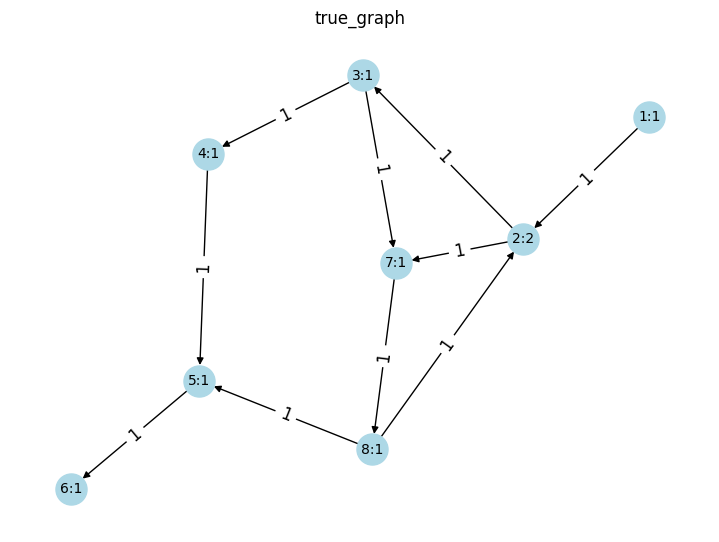

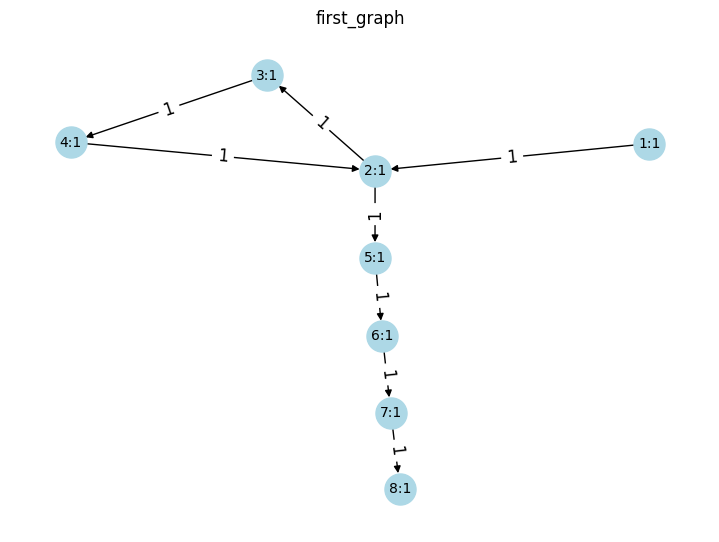

(10, 8)
{1: ['Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?'], 2: ['Certainly! Our approach to NFTs and digital assets is based on transparency and ethical collaborations. We ask influencers to clearly disclose any promotions related to digital assets and follow specific guidelines for creating and distributing content. Do you have any particular questions regarding these policies?', 'Of course! Our NFT and digital asset policies ensure that all collaborations are transparent and ethical. We require influencers to clearly disclose any digital asset promotions and adhere to specific guidelines regarding content creation and distribution. Do you have any specific questions about these policies?'], 3: ['Certainly! For content creation, we require that any digital asset promotions clearly state the nature of the asset, its authenticity, and any associated benefits or risks. Additionally, all distribution channels must comply with relevant re

{'is_same_structure': False,
 'triplet_match': {'node_mapping': {1: None,
   2: None,
   3: None,
   4: None,
   5: None,
   6: None,
   7: None,
   8: None},
  'edge_mapping': {'1->2': None,
   '2->3': None,
   '2->7': None,
   '3->4': None,
   '3->7': None,
   '4->5': None,
   '5->6': None,
   '7->8': None,
   '8->5': None,
   '8->2': None}}}

In [13]:
index = 0
new_dialogue = get_one_dialogue(dialogues, index)

with open("first_graph_ThreeStagesGen_o3mini.json", 'r', encoding="utf-8") as f:
    graph_dict = json.load(f)
first_graph = Graph(graph_dict=graph_dict)

true_graph.visualise_short('true_graph')
first_graph.visualise_short('first_graph')
validate_2_graphs(true_graph, first_graph)

**dialogue 1**

In [14]:
new_dialogue = get_one_dialogue(dialogues, 1)

assistant: Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?
user: I'd like to learn about your NFT policies.
assistant: Certainly! Our approach to NFTs and digital assets is based on transparency and ethical collaborations. We ask influencers to clearly disclose any promotions related to digital assets and follow specific guidelines for creating and distributing content. Do you have any particular questions regarding these policies?
user: Actually, can I change my inquiry?
assistant: Of course! How would you like to modify your inquiry?
user: I'd like to learn about the partnership benefits instead.
assistant: Certainly! Our partnerships offer various benefits including competitive compensation, exclusive access to our digital asset platforms, and opportunities for co-branded campaigns. We support our influencers with dedicated resources to maximize the impact of their content. Would you like more details or to proceed with an application?


In [15]:
result_graph = graph_generator_llm_2.invoke(dialogues[0:2], first_graph)
validate_one_graph(result_graph)

model:   gpt-3.5-turbo
LLM


INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


edges_match_nodes: True 
--------------
No duplicated nodes in the graph
---------------
Nodes: 9, edges: 10


In [16]:
with open("result_graph_llm_AppendChain_gpt35turbo_1.json", "w", encoding="utf-8") as file:
    json.dump(result_graph.graph_dict, file, indent=4, sort_keys=True)

# with open("result_graph_llm_AppendChain_gpt35turbo_1.json", 'r', encoding="utf-8") as f:
#     graph_dict = json.load(f)
# result_graph = Graph(graph_dict=graph_dict)

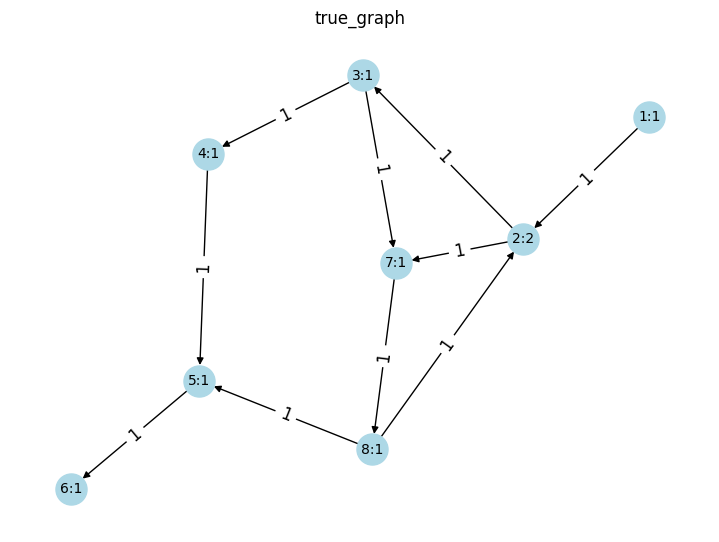

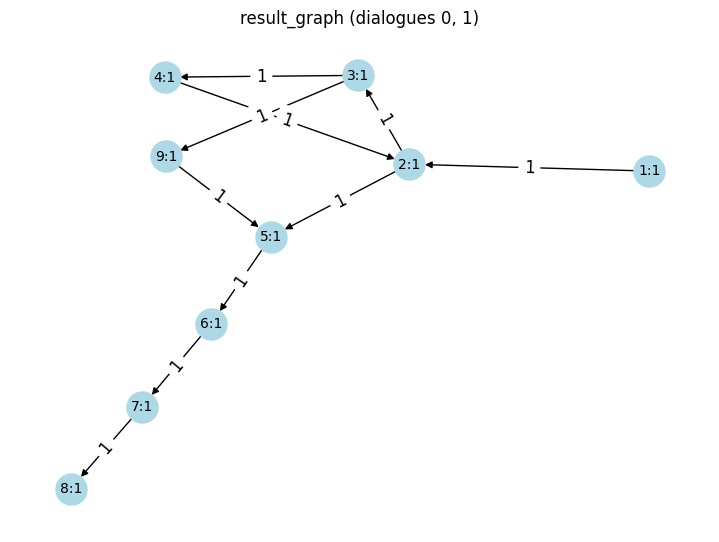

(10, 10)
{1: ['Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?'], 2: ['Certainly! Our approach to NFTs and digital assets is based on transparency and ethical collaborations. We ask influencers to clearly disclose any promotions related to digital assets and follow specific guidelines for creating and distributing content. Do you have any particular questions regarding these policies?', 'Of course! Our NFT and digital asset policies ensure that all collaborations are transparent and ethical. We require influencers to clearly disclose any digital asset promotions and adhere to specific guidelines regarding content creation and distribution. Do you have any specific questions about these policies?'], 3: ['Certainly! For content creation, we require that any digital asset promotions clearly state the nature of the asset, its authenticity, and any associated benefits or risks. Additionally, all distribution channels must comply with relevant r

{'is_same_structure': False,
 'triplet_match': {'node_mapping': {1: None,
   2: None,
   3: None,
   4: None,
   5: None,
   6: None,
   7: None,
   8: None,
   9: None},
  'edge_mapping': {'1->2': None,
   '2->3': None,
   '2->7': None,
   '3->4': None,
   '3->7': None,
   '4->5': None,
   '5->6': None,
   '7->8': None,
   '8->5': None,
   '8->2': None}}}

In [17]:
true_graph.visualise_short('true_graph')
result_graph.visualise_short('result_graph (dialogues 0, 1)')
validate_2_graphs(true_graph, result_graph)

**dialogue 2**

In [18]:
new_dialogue = get_one_dialogue(dialogues, 2)

assistant: Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?
user: I'd like to learn about your NFT policies.
assistant: Of course! Our NFT and digital asset policies ensure that all collaborations are transparent and ethical. We require influencers to clearly disclose any digital asset promotions and adhere to specific guidelines regarding content creation and distribution. Do you have any specific questions about these policies?
user: Actually, can I change my inquiry?
assistant: Of course! How would you like to modify your inquiry?
user: I'd like to learn about the partnership benefits instead.
assistant: Certainly! Our partnerships offer various benefits including competitive compensation, exclusive access to our digital asset platforms, and opportunities for co-branded campaigns. We support our influencers with dedicated resources to maximize the impact of their content. Would you like more details or to proceed with an application?
use

Генератор AppendChain рассчитан на 2 диалога (исходный и дополнительный)

In [20]:
result_graph = graph_generator_llm_2.invoke(dialogues[1:3], result_graph)
validate_one_graph(result_graph)

model:   gpt-3.5-turbo
LLM


INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


edges_match_nodes: True 
--------------
No duplicated nodes in the graph
---------------
Nodes: 9, edges: 11


In [21]:
with open("result_graph_llm_AppendChain_gpt35turbo_2.json", "w", encoding="utf-8") as file:
    json.dump(result_graph.graph_dict, file, indent=4, sort_keys=True)

# with open("result_graph_llm_AppendChain_gpt35turbo_2.json", 'r', encoding="utf-8") as f:
#     graph_dict = json.load(f)
# result_graph = Graph(graph_dict=graph_dict)

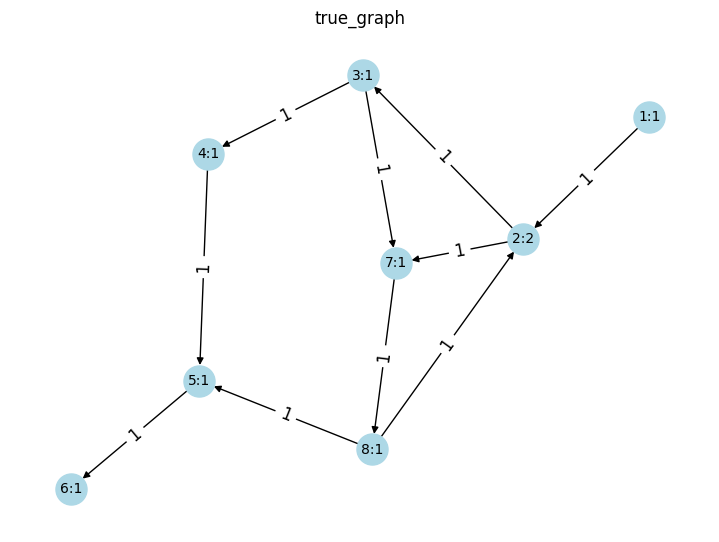

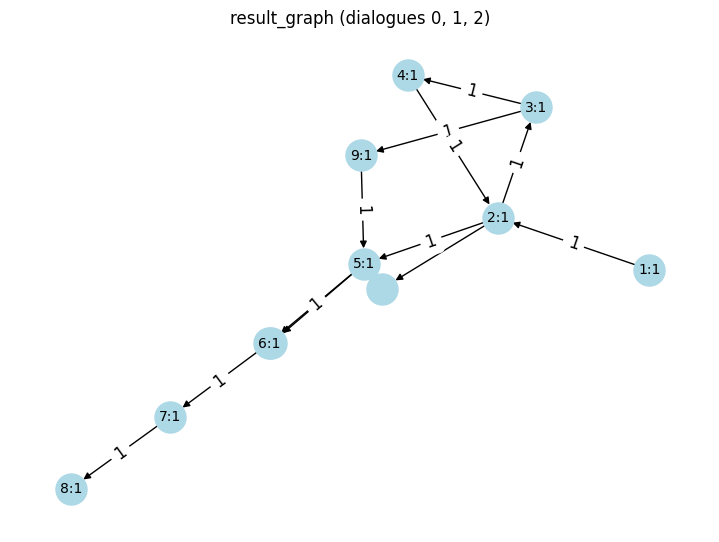

(10, 12)
{1: ['Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?'], 2: ['Certainly! Our approach to NFTs and digital assets is based on transparency and ethical collaborations. We ask influencers to clearly disclose any promotions related to digital assets and follow specific guidelines for creating and distributing content. Do you have any particular questions regarding these policies?', 'Of course! Our NFT and digital asset policies ensure that all collaborations are transparent and ethical. We require influencers to clearly disclose any digital asset promotions and adhere to specific guidelines regarding content creation and distribution. Do you have any specific questions about these policies?'], 3: ['Certainly! For content creation, we require that any digital asset promotions clearly state the nature of the asset, its authenticity, and any associated benefits or risks. Additionally, all distribution channels must comply with relevant r

{'is_same_structure': False,
 'triplet_match': {'node_mapping': {1: None,
   2: None,
   3: None,
   4: None,
   5: None,
   6: None,
   7: None,
   8: None,
   9: None,
   10: None,
   11: None},
  'edge_mapping': {'1->2': None,
   '2->3': None,
   '2->7': None,
   '3->4': None,
   '3->7': None,
   '4->5': None,
   '5->6': None,
   '7->8': None,
   '8->5': None,
   '8->2': None}}}

In [22]:
true_graph.visualise_short('true_graph')
result_graph.visualise_short('result_graph (dialogues 0, 1, 2)')
validate_2_graphs(true_graph, result_graph)

**dialogue 3**

In [23]:
new_dialogue = get_one_dialogue(dialogues, 3)

assistant: Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?
user: I'd like to learn about your NFT policies.
assistant: Certainly! Our approach to NFTs and digital assets is based on transparency and ethical collaborations. We ask influencers to clearly disclose any promotions related to digital assets and follow specific guidelines for creating and distributing content. Do you have any particular questions regarding these policies?
user: Can you provide more details on content guidelines?
assistant: Certainly! For content creation, we require that any digital asset promotions clearly state the nature of the asset, its authenticity, and any associated benefits or risks. Additionally, all distribution channels must comply with relevant regulations and our own standards for quality and accuracy. Would you like to discuss the partnership process next?
user: Actually, I want to change my question.
assistant: Of course! How would you like to mod

In [24]:
result_graph = graph_generator_llm_2.invoke(dialogues[2:4], result_graph)
validate_one_graph(result_graph)

model:   gpt-3.5-turbo
LLM


INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


edges_match_nodes: False 
--------------
No duplicated nodes in the graph
---------------
Nodes: 8, edges: 11


Граф не прошел валидацию "edges_match_nodes: False"

In [25]:
with open("result_graph_llm_AppendChain_gpt35turbo_3.json", "w", encoding="utf-8") as file:
    json.dump(result_graph.graph_dict, file, indent=4, sort_keys=True)

# with open("result_graph_llm_AppendChain_gpt35turbo_3.json", 'r', encoding="utf-8") as f:
#     graph_dict = json.load(f)
# result_graph = Graph(graph_dict=graph_dict)

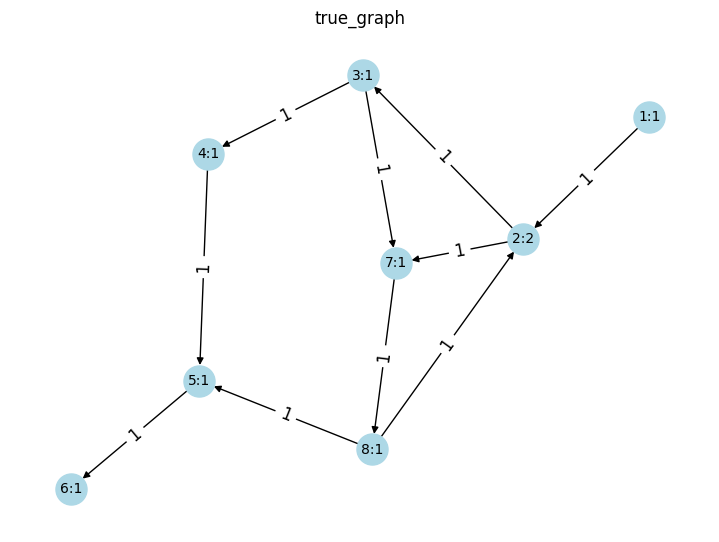

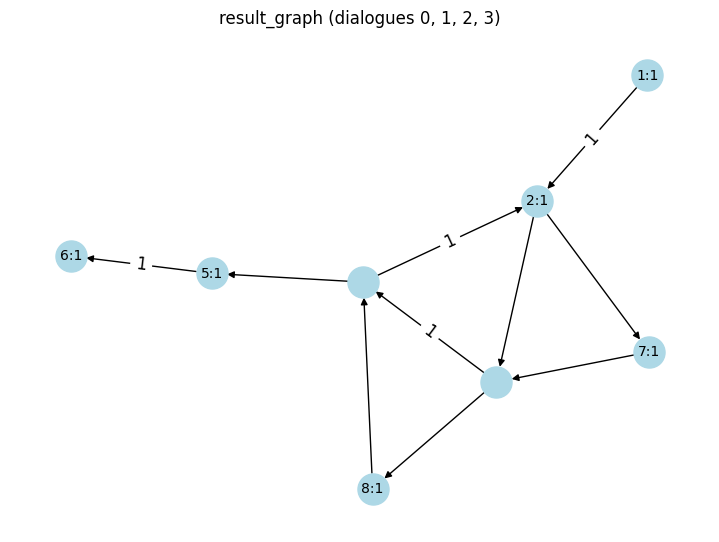

(10, 10)
{1: ['Hello! Thank you for reaching out about an influencer partnership. How can I assist you today?'], 2: ['Certainly! Our approach to NFTs and digital assets is based on transparency and ethical collaborations. We ask influencers to clearly disclose any promotions related to digital assets and follow specific guidelines for creating and distributing content. Do you have any particular questions regarding these policies?', 'Of course! Our NFT and digital asset policies ensure that all collaborations are transparent and ethical. We require influencers to clearly disclose any digital asset promotions and adhere to specific guidelines regarding content creation and distribution. Do you have any specific questions about these policies?'], 3: ['Certainly! For content creation, we require that any digital asset promotions clearly state the nature of the asset, its authenticity, and any associated benefits or risks. Additionally, all distribution channels must comply with relevant r

{'is_same_structure': False,
 'triplet_match': {'node_mapping': {1: None,
   2: None,
   3: None,
   4: None,
   5: None,
   6: None,
   7: None,
   8: None},
  'edge_mapping': {'1->2': None,
   '2->3': None,
   '2->7': None,
   '3->4': None,
   '3->7': None,
   '4->5': None,
   '5->6': None,
   '7->8': None,
   '8->5': None,
   '8->2': None}}}

In [26]:
true_graph.visualise_short('true_graph')
result_graph.visualise_short('result_graph (dialogues 0, 1, 2, 3)')
validate_2_graphs(true_graph, result_graph)

In [36]:
compare_graphs(result_graph, true_graph)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


LEN1:  [1, 1, 1, 1, 1, 1, 1, 1] LEN2:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

MAX:  [0, 1, 2, 3, 4, 5, 1, 6]
N_MAX:  [0, 1, 2, 3, 4, 5, 1, 6]
LLLLENS


False